# Libraries and packages

In [ ]:
%%capture
#Conventional libraries
import plotly.express as px

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
#NLP
import re
import string
from string import digits
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
#Sklearn
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import itertools
#Wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

# Functions

Función para el procesado de los tweets

In [ ]:
# Functions

def transform(text):
  stopwords = nltk.corpus.stopwords.words('spanish')
  stopwords.extend(["El", "Él", "el", "la", "los", "La", "Los", 
                  "hashtag", "si", "sí", "Sí", "dtype", "Index", "length", 
                  "object", "user", "...", "..", "¡", '``', "_", "°C", '___'])
  text = str(text)
  text = text.lower()
  text = re.sub(r'@[A-Za-z0-9]+', ' ', text) #Remover menciones @
  text = re.sub(r'RT[|\s]', ' ', text) # Remover RTs
  text = re.sub(r'#', ' ', text) #Remover # en el tweet
  text = re.sub(r'https?:\/\/\S+', ' ', text) #Remover links

  #Nuevas incluidas remove links
  text = re.sub(r'http\S+', ' ', text) # remove http links
  text = re.sub(r'bit.ly/\S+', ' ', text) # remove http links
  text = re.sub(r'pic.twitter\S+', ' ', text) # remove links
  text = text.strip('[link]') # remove links

  #Remove hashtags """Takes a string and removes any hash tags"""
  text = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', text)  # remove hash tags
  text = re.sub('HASHTAG', '', text)  # remove hash tags)
  text = re.sub('USER', '', text)  # remove hash tags)


  pattern = r'''(?x)                    # set flag to allow verbose regexps
              (?:[A-Z]\.)+            # abbreviations, e.g. U.S.A
              | \w+(?:-\w+)*          # Words with optional internal hyphens
              | \$?\d+(?:\.\d+)?%?    # Currency and precentages, e.g. $12.40 82%
              | \.\.\.                # Ellipsis
              | [][.,;"'?():-_`]      #These are separate tokens; includes ],[
              '''
  words = nltk.regexp_tokenize(text, pattern)
  re_punc = re.compile('[%s]' % re.escape(string.punctuation)) # Remover signos de puntuacion
  stripped = [re_punc.sub('', w) for w in words]
  no_garbage = [w for w in stripped if  w.lower() not in stopwords] # Remover stopwords

  return (" ".join(no_garbage))
def tokenization(text):
  text = word_tokenize(text.lower())
  return text
SS = SnowballStemmer('spanish')
def stemmer(text):
  text = [SS.stem(word) for word in text]
  return text


# Data cleaning

## Loading data

Se cargan los datos valorados por el algoritmo de Fernando.

In [ ]:
df1 = pd.read_csv("/content/drive/MyDrive/HaPyness/Programa valoración/220205/OUT_es.csv", 
                  encoding = "UTF8",
                  delimiter = ";")
df2 = df1.drop(['Unnamed: 0',	'ID'], axis = 1)
df2

,Texto_tweet,valoracion_corpus,valoracion_calculada
0,El Atlético resignado a perder HASHTAG 😔 http...,-1.0,-1.0
1,Leer proporciona una mejor visión del mundo 🤓 ...,1.0,1.0
2,Amo a Arya Stark por encima de todas las cosas...,1.0,0.0
3,Solo siento que hayamos perdido 24 escaños de ...,-1.0,-1.0
4,Solo con ver con la intensidad que agitan las ...,1.0,1.0
...,...,...,...
1971,Cuando pregunten quien es el mejor jugador en ...,1.0,0.0
1972,"Muchachos, es lamentable lo que le pasó a la c...",-1.0,-1.0
1973,Soy totalmente USER Mis mejores compras van ...,1.0,0.0
1974,La fachada de la catedral de Notre Dame fue “s...,-1.0,0.0


## NLP data

Se limpian los tweets y se tokenizan para crear listas de palabras. También, se aplica el stem para quitar las raíces. 

In [ ]:
df2["t1"] = df2['Texto_tweet'].apply(transform)
df2['t2'] = df2['t1'].apply(tokenization)
df2['t3'] = df2['t2'].apply(stemmer)
df2

,Texto_tweet,valoracion_corpus,valoracion_calculada,t1,t2,t3
0,El Atlético resignado a perder HASHTAG 😔 http...,-1.0,-1.0,atlético resignado perder,"[atlético, resignado, perder]","[atlet, resign, perd]"
1,Leer proporciona una mejor visión del mundo 🤓 ...,1.0,1.0,eer proporciona mejor visión mundo feliz,"[eer, proporciona, mejor, visión, mundo, feliz]","[eer, proporcion, mejor, vision, mund, feliz]"
2,Amo a Arya Stark por encima de todas las cosas...,1.0,0.0,amo arya stark encima todas cosas gameofthrones,"[amo, arya, stark, encima, todas, cosas, gameo...","[amo, arya, stark, encim, tod, cos, gameofthron]"
3,Solo siento que hayamos perdido 24 escaños de ...,-1.0,-1.0,solo siento perdido 24 escaños cordura,"[solo, siento, perdido, 24, escaños, cordura]","[sol, sient, perd, 24, escañ, cordur]"
4,Solo con ver con la intensidad que agitan las ...,1.0,1.0,solo ver intensidad agitan banderas ve quedado...,"[solo, ver, intensidad, agitan, banderas, ve, ...","[sol, ver, intens, agit, bander, ve, qued, sat..."
...,...,...,...,...,...,...
1971,Cuando pregunten quien es el mejor jugador en ...,1.0,0.0,pregunten mejor jugador historia griten lion...,"[pregunten, mejor, jugador, historia, griten, ...","[pregunt, mejor, jugador, histori, grit, lione..."
1972,"Muchachos, es lamentable lo que le pasó a la c...",-1.0,-1.0,muchachos lamentable pasó catedral notre dame...,"[muchachos, lamentable, pasó, catedral, notre,...","[muchach, lament, pas, catedral, notr, dam, em..."
1973,Soy totalmente USER Mis mejores compras van ...,1.0,0.0,totalmente mejores compras van dentro bolsa am...,"[totalmente, mejores, compras, van, dentro, bo...","[total, mejor, compr, van, dentr, bols, amaril..."
1974,La fachada de la catedral de Notre Dame fue “s...,-1.0,0.0,fachada catedral notre dame salvada podrá rest...,"[fachada, catedral, notre, dame, salvada, podr...","[fach, catedral, notr, dam, salv, podr, restau..."


# Exploratory analysis

Hacemos un análisis exploratorio de las palabras. La función explode es muy atractiva para ordernar las palabras tokenizadas y contarlas, ya sea para hacer nubes de palabras o gráficas de frecuencia. Cada palabra de la lista da como resultado una fila nueva. 

In [ ]:
df3 = df2.explode('t2').reset_index(drop = True)
df3.head()

,Texto_tweet,valoracion_corpus,valoracion_calculada,t1,t2,t3
0,El Atlético resignado a perder HASHTAG 😔 http...,-1.0,-1.0,atlético resignado perder,atlético,"[atlet, resign, perd]"
1,El Atlético resignado a perder HASHTAG 😔 http...,-1.0,-1.0,atlético resignado perder,resignado,"[atlet, resign, perd]"
2,El Atlético resignado a perder HASHTAG 😔 http...,-1.0,-1.0,atlético resignado perder,perder,"[atlet, resign, perd]"
3,Leer proporciona una mejor visión del mundo 🤓 ...,1.0,1.0,eer proporciona mejor visión mundo feliz,eer,"[eer, proporcion, mejor, vision, mund, feliz]"
4,Leer proporciona una mejor visión del mundo 🤓 ...,1.0,1.0,eer proporciona mejor visión mundo feliz,proporciona,"[eer, proporcion, mejor, vision, mund, feliz]"


## Wordcloud

## Before stemming

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

Para hacer la nube de palabras es necesario hacer un único string

In [ ]:
words = ' '.join(df3['t2'])
words

'atlético resignado perder eer proporciona mejor visión mundo feliz amo arya stark encima todas cosas gameofthrones solo siento perdido 24 escaños cordura solo ver intensidad agitan banderas ve quedado satisfechos sinceramente alegro muchísimo vez mejores jugadores historia leo messi 75 82 acabó serie hoy tarde oraciones pido amigos venezolanos hoy sufren opresión fin llegue pronto violencia lástima perdida incalculable lastima desaparece humanidad patrimonio pasa dias abre noticiarios dirigentes mundiales muestran pena posiblemente culpables uestra secretaria general felicita lectores destacados premiados amor libros incansable ganas viajar soñar aprender mediante palabras catedral media hora venirse abajo completamente daño notre dame irreparable adentramos templo tras incendio llorando maravilla obra arte espectacular alucinante increible majestuoso capítulo juego tronos cago muertos doy crédito acabo ver verdadera pena hace pocos meses pude ver propios ojos parís verdadera pena suc

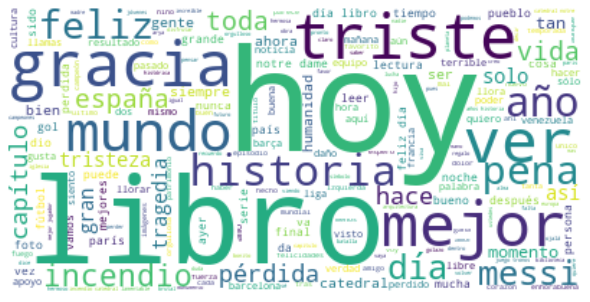

In [ ]:
wordcloud = WordCloud(stopwords = stopwords,background_color="white",
                      colormap = "viridis").generate(words)
# Display the generated image:
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)

- Fiveteen most used words

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 <a list of 16 Text major ticklabel objects>)

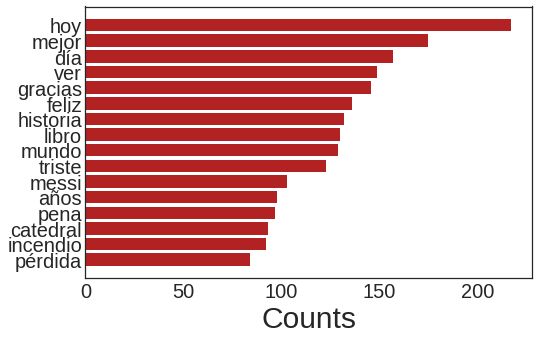

In [ ]:
a = df3['t2'].value_counts().sort_values(ascending = True).tail(16)
x = a.index
plt.figure(figsize = (8,5))
plt.style.use('seaborn-white')
plt.barh(x,a, color = "firebrick")
plt.xlabel("Counts", fontsize = 30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

## Después stemming

In [ ]:
df4 = df2.explode('t3').reset_index(drop = True)
df4.head(8)

,Texto_tweet,valoracion_corpus,valoracion_calculada,t1,t2,t3
0,El Atlético resignado a perder HASHTAG 😔 http...,-1.0,-1.0,atlético resignado perder,"[atlético, resignado, perder]",atlet
1,El Atlético resignado a perder HASHTAG 😔 http...,-1.0,-1.0,atlético resignado perder,"[atlético, resignado, perder]",resign
2,El Atlético resignado a perder HASHTAG 😔 http...,-1.0,-1.0,atlético resignado perder,"[atlético, resignado, perder]",perd
3,Leer proporciona una mejor visión del mundo 🤓 ...,1.0,1.0,eer proporciona mejor visión mundo feliz,"[eer, proporciona, mejor, visión, mundo, feliz]",eer
4,Leer proporciona una mejor visión del mundo 🤓 ...,1.0,1.0,eer proporciona mejor visión mundo feliz,"[eer, proporciona, mejor, visión, mundo, feliz]",proporcion
5,Leer proporciona una mejor visión del mundo 🤓 ...,1.0,1.0,eer proporciona mejor visión mundo feliz,"[eer, proporciona, mejor, visión, mundo, feliz]",mejor
6,Leer proporciona una mejor visión del mundo 🤓 ...,1.0,1.0,eer proporciona mejor visión mundo feliz,"[eer, proporciona, mejor, visión, mundo, feliz]",vision
7,Leer proporciona una mejor visión del mundo 🤓 ...,1.0,1.0,eer proporciona mejor visión mundo feliz,"[eer, proporciona, mejor, visión, mundo, feliz]",mund


In [ ]:
stemmed = ' '.join(df4['t3'])
stemmed

'atlet resign perd eer proporcion mejor vision mund feliz amo arya stark encim tod cos gameofthron sol sient perd 24 escañ cordur sol ver intens agit bander ve qued satisfech sincer alegr muchisim vez mejor jugador histori leo messi 75 82 acab seri hoy tard oracion pid amig venezolan hoy sufr opresion fin lleg pront violenci lastim perd incalcul lastim desaparec human patrimoni pas dias abre noticiari dirigent mundial muestr pen posibl culpabl uestr secretari general felicit lector destac premi amor libr incans gan viaj soñ aprend mediant palabr catedral medi hor ven abaj complet dañ notr dam irrepar adentr templ tras incendi llor maravill obra arte espectacul alucin increibl majestu capitul jueg tron cag muert doy credit acab ver verdader pen hac poc mes pud ver propi ojos par verdader pen suced dia hoy agradec noch graci verd consegu moviliz izquierd convert icon activ ecolog nivel planetari da esper ver joven pel maner encant inclu semifinal ida barcelon liverpool luz ilumin tod paz

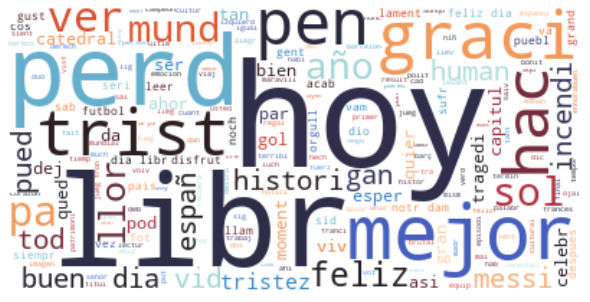

In [ ]:
wordcloud = WordCloud(stopwords = stopwords,background_color="white",
                      colormap = "icefire").generate(stemmed)
# Display the generated image:
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)

In [ ]:
a = df4['t3'].value_counts().sort_values(ascending = True).tail(16)
x = a.index
plt.figure(figsize = (8,5))
plt.style.use('seaborn-white')
plt.barh(x,a, color = "firebrick")
plt.xlabel("Counts", fontsize = 30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

# ML

## Data preparation

Preparamos los datos para poder aplicar ML. Para ello usaremos la columna t3 que es el *string stemmed* y aplicamos TFIDF, para crear la matriz numérica. 

In [ ]:
ml = df2[["Texto_tweet", "t3","valoracion_corpus", 'valoracion_calculada']]
ml2 = ml[ml['valoracion_calculada'] != 0].reset_index(drop = True)
ml2['t3'] = ml2['t3'].apply(lambda x: ' '.join(x))
ml2

,Texto_tweet,t3,valoracion_corpus,valoracion_calculada
0,El Atlético resignado a perder HASHTAG 😔 http...,atlet resign perd,-1.0,-1.0
1,Leer proporciona una mejor visión del mundo 🤓 ...,eer proporcion mejor vision mund feliz,1.0,1.0
2,Solo siento que hayamos perdido 24 escaños de ...,sol sient perd 24 escañ cordur,-1.0,-1.0
3,Solo con ver con la intensidad que agitan las ...,sol ver intens agit bander ve qued satisfech s...,1.0,1.0
4,¡Una vez más uno de los mejores jugadores de l...,vez mejor jugador histori leo messi 75 82 acab...,1.0,1.0
...,...,...,...,...
1409,🗓️HACE UN AÑO: HASHTAG se despedía del Barcel...,hac año desped barcelon echas men mag fuenteal...,-1.0,-1.0
1410,En este HASHTAG tengo más libros de literatura...,libr literatur hebre jamas imagin aun leid tan...,1.0,1.0
1411,El gol HASHTAG del mejor del mundo HASHTAG HAS...,gol mejor mund,1.0,1.0
1412,"Muchachos, es lamentable lo que le pasó a la c...",muchach lament pas catedral notr dam embarg tr...,-1.0,-1.0


In [ ]:
X = ml2['t3']
X

0                                       atlet resign perd
1                  eer proporcion mejor vision mund feliz
2                          sol sient perd 24 escañ cordur
3       sol ver intens agit bander ve qued satisfech s...
4       vez mejor jugador histori leo messi 75 82 acab...
                              ...                        
1409    hac año desped barcelon echas men mag fuenteal...
1410    libr literatur hebre jamas imagin aun leid tan...
1411                                       gol mejor mund
1412    muchach lament pas catedral notr dam embarg tr...
1413                                  sufr bars messi 2 0
Name: t3, Length: 1414, dtype: object

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

tfidfvectorizer = TfidfVectorizer()
tfidf_wm = tfidfvectorizer.fit_transform(X)
tfidf_tokens = tfidfvectorizer.get_feature_names_out()

ml3 = pd.DataFrame(data = tfidf_wm.toarray(),columns = tfidf_tokens)
ml4 = pd.concat((ml2[["valoracion_corpus", 'valoracion_calculada']], ml3), axis = 1)
ml4

,valoracion_corpus,valoracion_calculada,000,02,03,08,08x03,10,100,1000,102,11,116,1160,1163,12,1245,13,140,14h00,15,150,15m,16,163,17,18,1819,1863,187,19,1984,1988,1989,19942000,1995,1996,1er,20,200,...,vos,vot,votacion,votant,vox,voy,voz,vs,vuelt,vuelv,wey,whatsapps,winterfell,wird,xd,xenofobi,xi,xii,xiv,xq,yaaa,yes,youtub,yuuuuhuuuu,yuyu,zacatec,zon,zp,île,ñañañañañ,𝐀𝐍𝐃𝐀,𝐄𝐥,𝐋𝐄𝐄,𝐒𝐀𝐁𝐄,𝐕𝐄,𝐦𝐮𝐜𝐡𝐨,𝐪𝐮𝐞,𝑪𝒆𝒓𝒗𝒂𝒏𝒕𝒆𝒔,𝑴𝒊𝒈𝒖𝒆𝒍,𝒅𝒆
0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1409,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1410,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1411,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1412,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Valoracion corpus
Primero usamos diferentes modelos de ML para evaluar cuan bueno es el etiquetado humano. 

## Random Forest classifier

In [ ]:
ml5 = ml4.copy()
datos_X = ml5.drop(["valoracion_corpus",	"valoracion_calculada"], axis = 1)
datos_y = ml5['valoracion_corpus']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(datos_X,datos_y,test_size = 0.2,random_state = 123)


In [ ]:
modelRF = RandomForestClassifier(random_state = 123) #valores por defecto
modelRF = modelRF.fit(X_train, y_train)
modelRF

RandomForestClassifier(random_state=123)

In [ ]:
#EVALUATION
prediction_rf = modelRF.predict(X_test)
conf_rf       = confusion_matrix(y_test, prediction_rf)
acc_rf        = accuracy_score(y_test, prediction_rf)
prec_rf       = precision_score(y_test, prediction_rf, average="weighted")
rec_rf        = recall_score(y_test, prediction_rf, average="weighted")
f1_rf         = f1_score(y_test, prediction_rf, average="weighted")

print("Confusion Matrix: \n", conf_rf, '\n')
print("Accuracy    : ", acc_rf)
print("Recall      : ", prec_rf)
print("Precision   : ", rec_rf)
print("F1 Score    : ", f1_rf)

Confusion Matrix: 
 [[ 88  20]
 [  8 167]] 

Accuracy    :  0.901060070671378
Recall      :  0.9020615634625196
Precision   :  0.901060070671378
F1 Score    :  0.8997899610813616


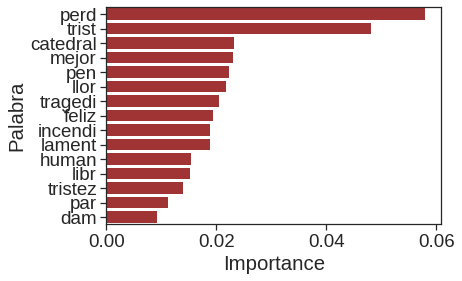

In [ ]:
importance = pd.DataFrame(modelRF.feature_importances_, columns = ["Importance"])
palabras = pd.DataFrame(list(datos_X.columns), columns = ["Palabra"])
corpus1 = pd.concat((palabras,importance), axis = 1)
corpus2 = corpus1.sort_values(by = 'Importance', ascending = False).reset_index(drop = True).head(15)
sns.set_context("notebook", font_scale = 1.7)
g = sns.barplot(data = corpus2, y = "Palabra", x = "Importance", color = "firebrick")

## SVM

In [ ]:
from sklearn import svm
modelSVM=svm.SVC(random_state = 1) #valores por defecto
modelSVM = modelSVM.fit(X_train, y_train)
modelSVM

SVC(random_state=1)

In [ ]:
prediction_svm = modelSVM.predict(X_test)
conf_svm       = confusion_matrix(y_test, prediction_svm)
acc_svm        = accuracy_score(y_test, prediction_svm)
prec_svm       = precision_score(y_test, prediction_svm, average="weighted")
rec_svm        = recall_score(y_test, prediction_svm, average="weighted")
f1_svm         = f1_score(y_test, prediction_svm, average="weighted")

print("Confusion Matrix: \n", conf_svm, '\n')
print("Accuracy    : ", acc_svm)
print("Recall      : ", prec_svm)
print("Precision   : ", rec_svm)
print("F1 Score    : ", f1_svm)

Confusion Matrix: 
 [[ 88  20]
 [  8 167]] 

Accuracy    :  0.901060070671378
Recall      :  0.9020615634625196
Precision   :  0.901060070671378
F1 Score    :  0.8997899610813616


## XGBoost

In [ ]:
from xgboost import XGBClassifier
modelXGB=XGBClassifier() #valores por defecto
modelXGB = modelXGB.fit(X_train, y_train)
modelXGB

XGBClassifier()

In [ ]:
prediction_xgb = modelXGB.predict(X_test)
conf_xgb      = confusion_matrix(y_test, prediction_xgb)
acc_xgb       = accuracy_score(y_test, prediction_xgb)
prec_xgb       = precision_score(y_test, prediction_xgb, average="weighted")
rec_xgb        = recall_score(y_test, prediction_xgb, average="weighted")
f1_xgb        = f1_score(y_test, prediction_xgb, average="weighted")

print("Confusion Matrix: \n", conf_xgb, '\n')
print("Accuracy    : ", acc_xgb)
print("Recall      : ", prec_xgb)
print("Precision   : ", rec_xgb)
print("F1 Score    : ", f1_xgb)

Confusion Matrix: 
 [[ 81  27]
 [  8 167]] 

Accuracy    :  0.8763250883392226
Recall      :  0.8796341509836323
Precision   :  0.8763250883392226
F1 Score    :  0.8735451121977276


In [ ]:
rf_C = pd.DataFrame({"Parameter":["Accuracy", "Recall", "Precision", "F1_score"], 
                    "Value":[acc_rf, prec_rf, rec_rf, f1_rf]})
rf_C["Model"] = "rf_C"
xgb = pd.DataFrame({"Parameter":["Accuracy", "Recall", "Precision", "F1_score"], 
                    "Value":[acc_xgb, prec_xgb, rec_xgb, f1_xgb]})
xgb["Model"] = "xgb"
svm = pd.DataFrame({"Parameter":["Accuracy", "Recall", "Precision", "F1_score"], 
                    "Value":[acc_svm, prec_svm, rec_svm, f1_svm]})
svm["Model"] = "svm"
models_corpus = pd.concat((rf_C, svm, xgb), axis = 0).reset_index(drop = True)
models_corpus["Valorador"] = "Corpus"

Almacenamos todos los datos en un dataframe.

Como podemos ver tiene una buena capacidad de predicción en base a los tweets limpios y stemmed. Los 3 modelos tienen en torno al 90%

# Valoracion Fernando

Se repite el proceso con los tweets etiquetados de manera automática

In [ ]:
ml5 = ml4.copy()
datos_X = ml5.drop(["valoracion_corpus",	"valoracion_calculada"], axis = 1)
datos_y = ml5['valoracion_calculada']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(datos_X,datos_y,test_size = 0.2,random_state = 123)


In [ ]:
modelRF = RandomForestClassifier(random_state = 123) #valores por defecto
modelRF = modelRF.fit(X_train, y_train)
modelRF

RandomForestClassifier(random_state=123)

In [ ]:
#EVALUATION
prediction_rf = modelRF.predict(X_test)
conf_rf       = confusion_matrix(y_test, prediction_rf)
acc_rf        = accuracy_score(y_test, prediction_rf)
prec_rf       = precision_score(y_test, prediction_rf, average="weighted")
rec_rf        = recall_score(y_test, prediction_rf, average="weighted")
f1_rf         = f1_score(y_test, prediction_rf, average="weighted")

print("Confusion Matrix: \n", conf_rf, '\n')
print("Accuracy    : ", acc_rf)
print("Recall      : ", prec_rf)
print("Precision   : ", rec_rf)
print("F1 Score    : ", f1_rf)

Confusion Matrix: 
 [[113  40]
 [  3 127]] 

Accuracy    :  0.8480565371024735
Recall      :  0.875990738153278
Precision   :  0.8480565371024735
F1 Score    :  0.8470713855399972


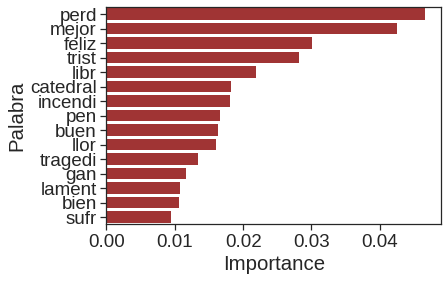

In [ ]:
importance = pd.DataFrame(modelRF.feature_importances_, columns = ["Importance"])
palabras = pd.DataFrame(list(datos_X.columns), columns = ["Palabra"])
fer1 = pd.concat((palabras,importance), axis = 1)
fer2 = fer1.sort_values(by = 'Importance', ascending = False).reset_index(drop = True).head(15)
sns.set_context("notebook", font_scale = 1.7)
g = sns.barplot(data = fer2, y = "Palabra", x = "Importance", color = "firebrick")

## SVM

### Valoracion Fernando

In [ ]:
from sklearn import svm
modelSVM=svm.SVC(random_state = 1) #valores por defecto
modelSVM = modelSVM.fit(X_train, y_train)
modelSVM

SVC(random_state=1)

In [ ]:
prediction_svm = modelSVM.predict(X_test)
conf_svm       = confusion_matrix(y_test, prediction_svm)
acc_svm        = accuracy_score(y_test, prediction_svm)
prec_svm       = precision_score(y_test, prediction_svm, average="weighted")
rec_svm        = recall_score(y_test, prediction_svm, average="weighted")
f1_svm         = f1_score(y_test, prediction_svm, average="weighted")

print("Confusion Matrix: \n", conf_svm, '\n')
print("Accuracy    : ", acc_svm)
print("Recall      : ", prec_svm)
print("Precision   : ", rec_svm)
print("F1 Score    : ", f1_svm)

Confusion Matrix: 
 [[121  32]
 [  5 125]] 

Accuracy    :  0.8692579505300353
Recall      :  0.8849178662259619
Precision   :  0.8692579505300353
F1 Score    :  0.8690816096742817


## XGBoost

In [ ]:
from xgboost import XGBClassifier
modelXGB=XGBClassifier() #valores por defecto
modelXGB = modelXGB.fit(X_train, y_train)
modelXGB

XGBClassifier()

In [ ]:
prediction_xgb = modelXGB.predict(X_test)
conf_xgb      = confusion_matrix(y_test, prediction_xgb)
acc_xgb       = accuracy_score(y_test, prediction_xgb)
prec_xgb       = precision_score(y_test, prediction_xgb, average="weighted")
rec_xgb        = recall_score(y_test, prediction_xgb, average="weighted")
f1_xgb        = f1_score(y_test, prediction_xgb, average="weighted")

print("Confusion Matrix: \n", conf_xgb, '\n')
print("Accuracy    : ", acc_xgb)
print("Recall      : ", prec_xgb)
print("Precision   : ", rec_xgb)
print("F1 Score    : ", f1_xgb)

Confusion Matrix: 
 [[138  15]
 [ 30 100]] 

Accuracy    :  0.8409893992932862
Recall      :  0.8435408116234665
Precision   :  0.8409893992932862
F1 Score    :  0.839836928794172


In [ ]:
rf_F = pd.DataFrame({"Parameter":["Accuracy", "Recall", "Precision", "F1_score"], 
                    "Value":[acc_rf, prec_rf, rec_rf, f1_rf]})
rf_F["Model"] = "rf_F"
xgb = pd.DataFrame({"Parameter":["Accuracy", "Recall", "Precision", "F1_score"], 
                    "Value":[acc_xgb, prec_xgb, rec_xgb, f1_xgb]})
xgb["Model"] = "xgb"
svm = pd.DataFrame({"Parameter":["Accuracy", "Recall", "Precision", "F1_score"], 
                    "Value":[acc_svm, prec_svm, rec_svm, f1_svm]})
svm["Model"] = "svm"
models_fernando = pd.concat((rf_F, svm, xgb), axis = 0).reset_index(drop = True)
models_fernando["Valorador"] = "Fernando"

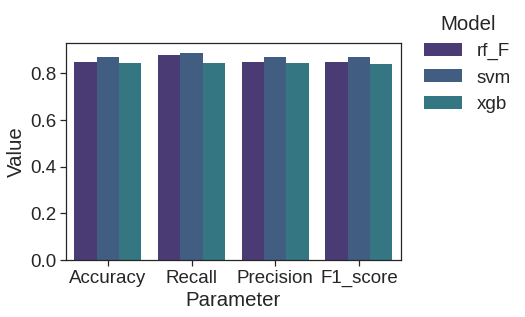

In [ ]:
sns.set_context("notebook", font_scale = 1.7)
sns.set_palette("viridis")
a = sns.barplot(data = models_fernando, x = "Parameter", y = "Value", hue = "Model")
sns.move_legend(a, "lower center", bbox_to_anchor=(1.2, 0.6), title="Model", frameon=False)


Los tres modelos tienen características similares

## Model comparison

In [ ]:
models = pd.concat((models_fernando, models_corpus), axis = 0)

In [ ]:
models = models.replace({'Model':{'rf_F':"rf", 'rf_C':"rf"}})

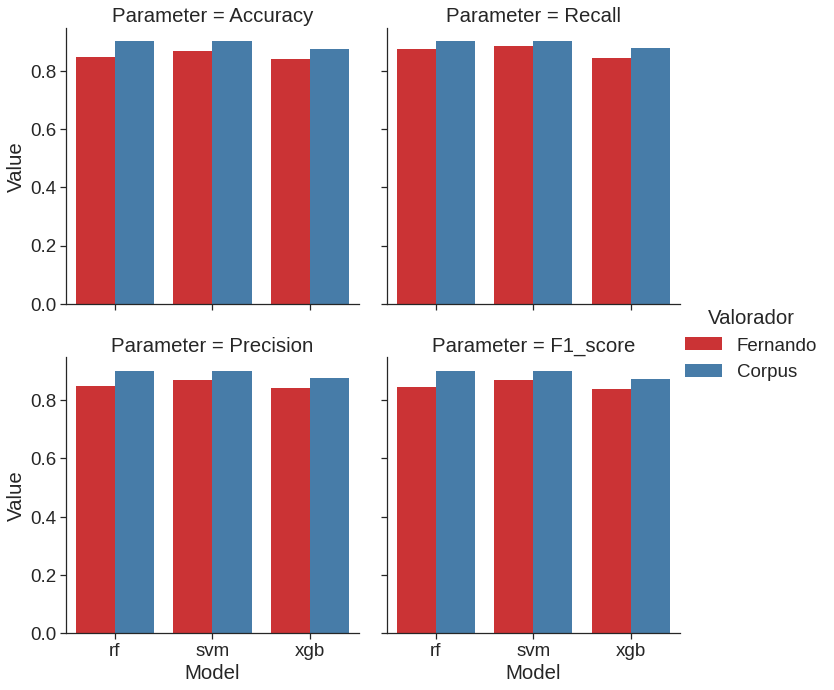

In [ ]:
sns.set_context("notebook", font_scale = 1.7)
sns.set_palette("Set1")
a = sns.catplot(data = models,kind = "bar",
                x = "Model", y = "Value", 
                hue = "Valorador", col = "Parameter", 
                col_wrap = 2,legend = "brief")
#sns.move_legend(a, "lower center", bbox_to_anchor=(1.2, 0.6), title="Model", frameon=False)


Como se puede ver, el modelo usando el etiquetado humano da mejores resultados. Por ello, queremos explorar si mejorando el modelo con el etiquetado automático podemos crear un modelo más robusto

# Hyperparameter tunning

# Corpus - Random Forest

In [ ]:
ml5 = ml4.copy()
datos_X = ml5.drop(["valoracion_corpus",	"valoracion_calculada"], axis = 1)
datos_y = ml5['valoracion_corpus']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(datos_X,datos_y,test_size = 0.2,random_state = 123)


Se usa un random grid para explorar los mejores hiperparámetros. Este trozo de código se puede encontrar descrito un numerosos sitios en Internet

In [ ]:
'''
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 30, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
'''

'\n# Use the random grid to search for best hyperparameters\n# First create the base model to tune\nrf = RandomForestClassifier()\n# Random search of parameters, using 3 fold cross validation, \n# search across 100 different combinations, and use all available cores\nrf_random = RandomizedSearchCV(estimator = rf, \n                               param_distributions = random_grid, \n                               n_iter = 30, \n                               cv = 3, \n                               verbose=2, \n                               random_state=42, \n                               n_jobs = -1)\n# Fit the random search model\nrf_random.fit(X_train, y_train)\n'

In [ ]:
#rf_random.best_params_


In [ ]:
modelRF = RandomForestClassifier(
                                 bootstrap = False,
                                 max_depth = 60,
                                 max_features = 'sqrt',
                                 min_samples_leaf = 1,
                                 min_samples_split = 10,
                                 n_estimators = 400,
                                 random_state = 123
                                 ) #valores por defecto
modelRF = modelRF.fit(X_train, y_train)
modelRF

RandomForestClassifier(bootstrap=False, max_depth=60, max_features='sqrt',
                       min_samples_split=10, n_estimators=400,
                       random_state=123)

In [ ]:
prediction_rf = modelRF.predict(X_test)
conf_rf       = confusion_matrix(y_test, prediction_rf)
acc_rf        = accuracy_score(y_test, prediction_rf)
prec_rf       = precision_score(y_test, prediction_rf, average="weighted")
rec_rf        = recall_score(y_test, prediction_rf, average="weighted")
f1_rf         = f1_score(y_test, prediction_rf, average="weighted")

print("Confusion Matrix: \n", conf_rf, '\n')
print("Accuracy    : ", acc_rf)
print("Recall      : ", prec_rf)
print("Precision   : ", rec_rf)
print("F1 Score    : ", f1_rf)

Confusion Matrix: 
 [[ 89  19]
 [  9 166]] 

Accuracy    :  0.901060070671378
Recall      :  0.901444027138121
Precision   :  0.901060070671378
F1 Score    :  0.9000327817611429


In [ ]:
rf_CV = pd.DataFrame({"Parameter":["Accuracy", "Recall", "Precision", "F1_score"], 
                    "Value":[acc_rf, prec_rf, rec_rf, f1_rf]})
rf_CV["Model"] = "rf_CV"

In [ ]:
rf_summary = pd.concat((rf_C, rf_CV), axis = 0)
rf_summary

,Parameter,Value,Model
0,Accuracy,0.901060,rf_C
1,Recall,0.902062,rf_C
2,Precision,0.901060,rf_C
3,F1_score,0.899790,rf_C
0,Accuracy,0.901060,rf_CV
1,Recall,0.901444,rf_CV
2,Precision,0.901060,rf_CV
3,F1_score,0.900033,rf_CV


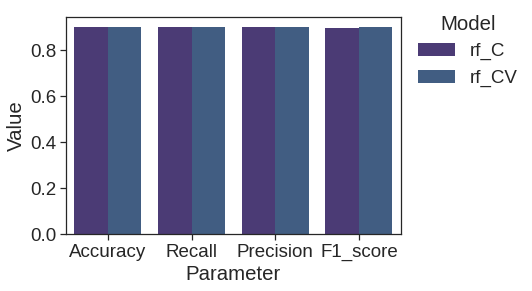

In [ ]:
sns.set_context("notebook", font_scale = 1.7)
sns.set_palette("viridis")
a = sns.barplot(data = rf_summary, x = "Parameter", y = "Value", hue = "Model")
sns.move_legend(a, "lower center", bbox_to_anchor=(1.2, 0.6), title="Model", frameon=False)


No mejoramos el modelo de forma significativa. El etiquetado humano es bastante robusto

# Fernando RF

Repetimos la búsqueda de hiperparámetros anterior para el etiquetado automático

In [ ]:
ml5 = ml4.copy()
datos_X = ml5.drop(["valoracion_corpus",	"valoracion_calculada"], axis = 1)
datos_y = ml5['valoracion_calculada']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(datos_X,datos_y,test_size = 0.2,random_state = 123)


In [ ]:
'''
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
'''

In [ ]:
'''
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 30 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
'''

In [ ]:
#rf_random.best_params_


In [ ]:
modelRF = RandomForestClassifier(
                                 bootstrap = False,
                                 max_depth = None,
                                 max_features = 'sqrt',
                                 min_samples_leaf = 1,
                                 min_samples_split = 2,
                                 n_estimators = 400,
                                 random_state = 123
                                 ) #valores por defecto
modelRF = modelRF.fit(X_train, y_train)
modelRF

RandomForestClassifier(bootstrap=False, max_features='sqrt', n_estimators=400,
                       random_state=123)

In [ ]:
prediction_rf = modelRF.predict(X_test)
conf_rf       = confusion_matrix(y_test, prediction_rf)
acc_rf        = accuracy_score(y_test, prediction_rf)
prec_rf       = precision_score(y_test, prediction_rf, average="weighted")
rec_rf        = recall_score(y_test, prediction_rf, average="weighted")
f1_rf         = f1_score(y_test, prediction_rf, average="weighted")

print("Confusion Matrix: \n", conf_rf, '\n')
print("Accuracy    : ", acc_rf)
print("Recall      : ", prec_rf)
print("Precision   : ", rec_rf)
print("F1 Score    : ", f1_rf)

Confusion Matrix: 
 [[126  27]
 [  5 125]] 

Accuracy    :  0.8869257950530035
Recall      :  0.8977674914500126
Precision   :  0.8869257950530035
F1 Score    :  0.8869568562920012


In [ ]:
rf_CV_F = pd.DataFrame({"Parameter":["Accuracy", "Recall", "Precision", "F1_score"], 
                    "Value":[acc_rf, prec_rf, rec_rf, f1_rf]})
rf_CV_F["Model"] = "rf_CV"

In [ ]:
rf_summary = pd.concat((rf_F, rf_CV_F), axis = 0)
rf_summary

,Parameter,Value,Model
0,Accuracy,0.848057,rf_F
1,Recall,0.875991,rf_F
2,Precision,0.848057,rf_F
3,F1_score,0.847071,rf_F
0,Accuracy,0.886926,rf_CV
1,Recall,0.897767,rf_CV
2,Precision,0.886926,rf_CV
3,F1_score,0.886957,rf_CV


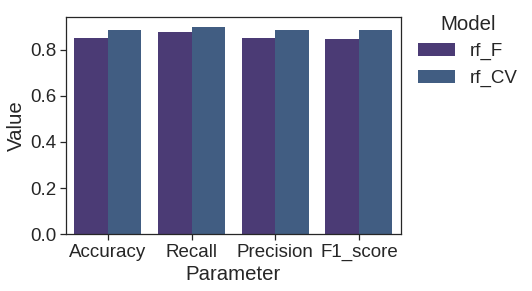

In [ ]:
sns.set_context("notebook", font_scale = 1.7)
sns.set_palette("viridis")
a = sns.barplot(data = rf_summary, x = "Parameter", y = "Value", hue = "Model")
sns.move_legend(a, "lower center", bbox_to_anchor=(1.2, 0.6), title="Model", frameon=False)


☝ ¡eh! ¡que mejoramos de forma significativa!
Vamos a guardar el modelo, por si las moscas 🪰

# Export model with all features

In [ ]:
# save the model to disk
import os
import joblib
os.chdir('/content/drive/MyDrive/HaPyness')
import pickle
joblib.dump(modelRF, "model.pkl")


['model.pkl']